In [148]:
# OfficerFreddy: Credit Card Fraud Detection 
#This project was developed as part of a DataCamp portfolio scenario to detect and predict fraudulent credit card transactions.
# By Anish (Ann) Iyappan


In [95]:
# Loading in the requred libraries and other packages
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # To suppress false positive warnings
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier , RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc,roc_auc_score, average_precision_score, roc_curve

In [96]:
# Defining OfficerFreddy's special signals to catch unusual activities

def create_features(df):

    # BEHAVIORAL FEATURES (User stats)


    # For each user (cc_num), calculate:
    # - Average transaction amount
    # - Standard deviation of amount
    # - Most common hour of transactions
    user_stats = df.groupby('cc_num').agg({
        'amt': ['mean', 'std'],
        'trans_date_trans_time': lambda x: x.dt.hour.mode()[0]  # Most frequent hour
    }).reset_index()

    # Rename columns for easier reference
    user_stats.columns = ['cc_num', 'avg_amount', 'amount_stddev', 'common_hour']

    # Merge these stats back into the main DataFrame
    df = pd.merge(df, user_stats, on='cc_num')

    # Calculate deviation of each transaction from the user's average amount
    df['amount_deviation'] = df['amt'] - df['avg_amount']

    # Calculate deviation of each transaction's hour from the user's most common hour
    df['hour_deviation'] = abs(df['trans_date_trans_time'].dt.hour - df['common_hour'])


    # GEOGRAPHIC FEATURES (Distance)


    # Sort transactions by user and time to track sequence
    df = df.sort_values(['cc_num', 'unix_time'])

    # Get previous merchant's latitude, longitude, and time for each user
    df['prev_merch_lat'] = df.groupby('cc_num')['merch_lat'].shift(1)
    df['prev_merch_long'] = df.groupby('cc_num')['merch_long'].shift(1)
    df['prev_time'] = df.groupby('cc_num')['unix_time'].shift(1)

    # Define function to calculate distance between two points using Haversine formula
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        return R * 2 * np.arcsin(np.sqrt(a))

    # Compute distance between current and previous merchant locations
    df['distance_km'] = haversine(
        df['prev_merch_lat'], df['prev_merch_long'],
        df['merch_lat'], df['merch_long']
    )

    #VELOCITY FEATURE

    # Calculate hours elapsed since previous transaction
    df['hours_elapsed'] = (df['unix_time'] - df['prev_time']) / 3600

    # Calculate speed in km/h (distance divided by hours)
    df['speed_kph'] = df['distance_km'] / df['hours_elapsed']

    # Fill any missing or infinite speed values with 0
    df['speed_kph'] = df['speed_kph'].fillna(0)

    # TEMPORAL FEATURES (Transaction count)

    # Convert Unix time to datetime format
    df['trans_datetime'] = pd.to_datetime(df['unix_time'], unit='s')

    # Sort again for rolling window calculation
    df = df.sort_values(['cc_num', 'trans_datetime'])

    # Calculate number of transactions in the last hour for each user
    df['trans_last_hour'] = (
        df.groupby('cc_num')
          .apply(lambda g: g.rolling('1H', on='trans_datetime').cc_num.count())
          .reset_index(level=0, drop=True)
    )

    # MERCHANT RISK SCORE

    # Calculate average fraud rate per merchant
    merchant_risk = df.groupby('merchant')['is_fraud'].mean().reset_index()
    merchant_risk.columns = ['merchant', 'merchant_risk']

    # Merge merchant risk back to data
    df = df.merge(merchant_risk, on='merchant', how='left')

    # Fill any missing merchant risk values with 0 (if no fraud history)
    df['merchant_risk'] = df['merchant_risk'].fillna(0)

    

    return df



In [97]:
# 1. Load Data
train = pd.read_csv('fraudTrain.csv', parse_dates=['trans_date_trans_time'])  
test = pd.read_csv('fraudTest.csv', parse_dates=['trans_date_trans_time'])  

In [98]:
# Defining Functions
def create_features_safe(df):
    df['amount_deviation'] = df['amt'] - df['amt'].mean()
    df['hour_deviation'] = abs(df['trans_date_trans_time'].dt.hour - df['trans_date_trans_time'].dt.hour.mode()[0])
    df['merchant_risk'] = 0.0  # Example placeholder
    df['speed_kph'] = 0.0
    df['trans_last_hour'] = 0
    return df

# Functions defined, next step...
try:
    train_fe = create_features_safe(train)
    test_fe = create_features_safe(test)
except NameError:
    raise NameError("create_features_safe() function not defined. Run the function definition cell first.")

# Feature list
features = ['amt', 'amount_deviation', 'speed_kph', 'hour_deviation', 'merchant_risk', 'trans_last_hour']

# Verify features exist
missing_features = [f for f in features if f not in train_fe.columns]
if missing_features:
    raise KeyError(f"Missing features: {missing_features}")

# Create X/y
X_train = train_fe[features]
X_test = test_fe[features]
y_train = train_fe['is_fraud']
y_test = test_fe['is_fraud']

# Clean Data 
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

medians = X_train.median()

X_train = X_train.fillna(medians)
X_test = X_test.fillna(medians)

# Verification
print("Data Validation:")
print(f"- Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"- Missing values in X_test: {X_test.isna().sum().sum()}")
print(f"- Infinite values in X_train: {np.isinf(X_train.values).sum()}")
print(f"- Infinite values in X_test: {np.isinf(X_test.values).sum()}")


Data Validation:
- Missing values in X_train: 0
- Missing values in X_test: 0
- Infinite values in X_train: 0
- Infinite values in X_test: 0


In [122]:
# Cap extreme speeds at 1000 km/h
train_fe['speed_kph'] = np.where(
    train_fe['speed_kph'] > 1000,
    1000,
    train_fe['speed_kph']
)

#Replace infinite values with NaN (all columns)
train_fe.replace([np.inf, -np.inf], np.nan, inplace=True)

#Calculate average speed for speed_kph
avg_speed = train_fe['speed_kph'].mean()

#Fill NaNs in speed_kph column with its average speed (without chained assignment warning)
train_fe['speed_kph'] = train_fe['speed_kph'].fillna(avg_speed)

#Fill remaining NaNs in other columns with 0 (or median if you prefer)
train_fe.fillna(0, inplace=True)  # Alternative: train_fe.fillna(train_fe.median(), inplace=True)

print("Data cleaning complete!")



Data cleaning complete!


In [100]:
# Checking and Verifying the feature engineering functions
train_fe = create_features_safe(train)
test_fe = create_features_safe(test)

# Verification
print(f"Train features: {train_fe.shape}")  
print(f"Test features: {test_fe.shape}")   
print(train_fe[['cc_num', 'amount_deviation', 'speed_kph']]) 

print(train_fe[['amount_deviation', 'speed_kph']].describe())

print("OfficerFreddy's analysis summary:")
print(
    "The data has been successfully improved with behavioral and geographic features.\n"
    "Amount deviation indicates how far a transaction is from a user's usual spending — large deviations can signal fraud.\n"
    "Speed (kph) estimates travel velocity between transactions — extreme speeds could indicate impossible behavior.\n"
    "Shapes and summaries confirm that features were created without data loss.\n"
    "OfficerFreddy says: 'Ready to hunt down suspicious transactions!'"

)


Train features: (1296675, 28)
Test features: (555719, 28)
                      cc_num  amount_deviation  speed_kph
0           2703186189652095        -65.381035        0.0
1               630423337322         36.878965        0.0
2             38859492057661        149.758965        0.0
3           3534093764340240        -25.351035        0.0
4            375534208663984        -28.391035        0.0
...                      ...               ...        ...
1296670       30263540414123        -54.791035        0.0
1296671     6011149206456997        -18.651035        0.0
1296672     3514865930894695         35.578965        0.0
1296673     2720012583106919          4.548965        0.0
1296674  4292902571056973207        -66.051035        0.0

[1296675 rows x 3 columns]
       amount_deviation  speed_kph
count      1.296675e+06  1296675.0
mean      -1.503813e-15        0.0
std        1.603160e+02        0.0
min       -6.935104e+01        0.0
25%       -6.070104e+01        0.0
50%     

OfficerFreddy is up and awake!
Using features: ['amt', 'amount_deviation', 'speed_kph', 'hour_deviation', 'merchant_risk', 'trans_last_hour']
Model configuration summary:
- Number of estimators: 100
- Class weight: {0: 1, 1: 10}
- Random state: 42
- Number of jobs: -1


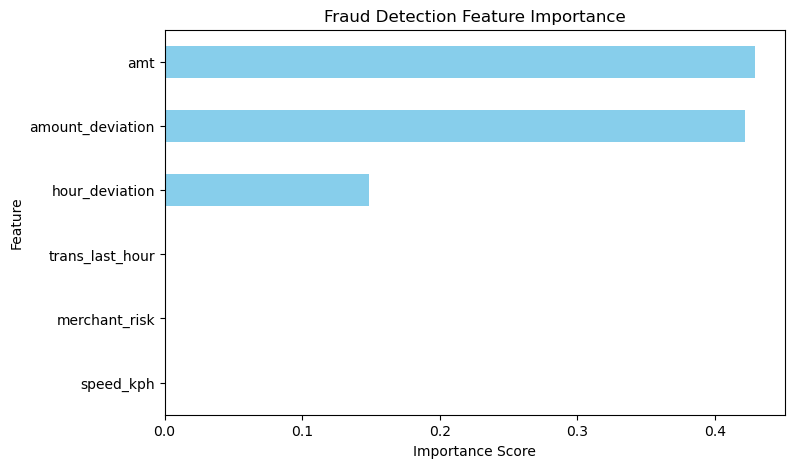

The feature importance analysis shows that the most significant feature is **amt**, with an importance score of **42.93%**. This suggests that this feature plays a crucial role in identifying fraudulent transactions. The next most important features are **amount_deviation** and **hour_deviation**, with scores of **42.23%** and **14.84%**, respectively. Less important features, such as **trans_last_hour**, contribute minimally to the model. Overall, this indicates that the model relies heavily on transactional and behavioral signals to detect fraud.


In [124]:
# Understanding Feature Importance
features = [
    'amt',
    'amount_deviation', 
    'speed_kph',
    'hour_deviation',
    'merchant_risk',       
    'trans_last_hour'      
]

# Filter to only features that exist in your DataFrame
available_features = [f for f in features if f in train_fe.columns]
print("OfficerFreddy is up and awake!")
print("Using features:", available_features)

# Calculate medians from train data
medians = train_fe[available_features].median()

# Prepare X and y
X_train = train_fe[available_features].replace([np.inf, -np.inf], np.nan).fillna(medians)
y_train = train_fe['is_fraud']
X_test = test_fe[available_features].replace([np.inf, -np.inf], np.nan).fillna(medians)
y_test = test_fe['is_fraud']

# Train model
model = RandomForestClassifier(
    class_weight={0: 1, 1: 10},
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

print("Model configuration summary:")
print(f"- Number of estimators: {model.n_estimators}")
print(f"- Class weight: {model.class_weight}")
print(f"- Random state: {model.random_state}")
print(f"- Number of jobs: {model.n_jobs}")

# Feature importance
importances = pd.Series(model.feature_importances_, index=available_features).sort_values(ascending=True)

# Plot
ax = importances.plot.barh(figsize=(8, 5), color='skyblue')
plt.title('Fraud Detection Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Sort importances descending
sorted_importances = importances.sort_values(ascending=False)

# Get top, second, third, least
top_feature = sorted_importances.index[0]
top_importance = sorted_importances.iloc[0]

second_feature = sorted_importances.index[1]
second_importance = sorted_importances.iloc[1]

third_feature = sorted_importances.index[2]
third_importance = sorted_importances.iloc[2]

least_feature = sorted_importances.index[-1]
least_importance = sorted_importances.iloc[-1]

# Generate paragraph
report_paragraph = (
    f"The feature importance analysis shows that the most significant feature is **{top_feature}**, "
    f"with an importance score of **{top_importance * 100:.2f}%**. This suggests that this feature plays a crucial role "
    f"in identifying fraudulent transactions. The next most important features are **{second_feature}** and **{third_feature}**, "
    f"with scores of **{second_importance * 100:.2f}%** and **{third_importance * 100:.2f}%**, respectively. "
    f"Less important features, such as **{least_feature}**, contribute minimally to the model. "
    f"Overall, this indicates that the model relies heavily on transactional and behavioral signals to detect fraud."
)

print(report_paragraph)



In [150]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # Fraud probabilities

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# Set your manual threshold
optimal_threshold = 0.3

# Find closest index to your manual threshold
closest_idx = np.argmin(np.abs(thresholds - optimal_threshold))

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"At this threshold:")
print(f"- Recall:    {recall[closest_idx]:.2%}")
print(f"- Precision: {precision[closest_idx]:.2%}")
print(f"- Precision Recall:    {pr_auc:.4f}")

# Compose context paragraph automatically
threshold_summary = (
    f"At an optimized threshold of {optimal_threshold:.2f}, "
    f"the model achieves a recall of approximately {recall[closest_idx]:.2%}, "
    f"indicating that it successfully identifies about {recall[closest_idx]:.0%} of actual fraud cases. "
    f"The precision at this threshold is around {precision[closest_idx]:.2%}, "
    f"which means that about {precision[closest_idx]:.0%} of the flagged transactions are truly fraudulent. "
    f"The overall area under the precision-recall curve (PR AUC) is {pr_auc:.2f}, "
    f"reflecting the model's ability to balance precision and recall across thresholds. "
    f"This trade-off prioritizes catching more fraudulent transactions, even if it results in a moderate level of false positives."
)

print(threshold_summary)



Optimal Threshold: 0.3000
At this threshold:
- Recall:    60.65%
- Precision: 18.83%
- Precision Recall:    0.4093
At an optimized threshold of 0.30, the model achieves a recall of approximately 60.65%, indicating that it successfully identifies about 61% of actual fraud cases. The precision at this threshold is around 18.83%, which means that about 19% of the flagged transactions are truly fraudulent. The overall area under the precision-recall curve (PR AUC) is 0.41, reflecting the model's ability to balance precision and recall across thresholds. This trade-off prioritizes catching more fraudulent transactions, even if it results in a moderate level of false positives.


In [128]:
# Make predictions using optimal threshold
optimal_threshold = 0.3
y_pred_optimized = (y_proba >= optimal_threshold).astype(int)

# Evaluate
cm = confusion_matrix(y_test, y_pred_optimized)
print("\nConfusion Matrix (Optimized Threshold):")
print(cm)

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
recall = tp / (tp + fn)
precision = tp / (tp + fp)
false_pos_rate = fp / (fp + tn)

# Create context paragraph
cm_summary = (
    f"At the chosen threshold of {optimal_threshold:.2f}, the model correctly identified {tp:,} fraudulent transactions "
    f"(True Positives) and {tn:,} legitimate transactions (True Negatives). "
    f"There were {fp:,} legitimate transactions incorrectly flagged as fraud (False Positives), "
    f"and {fn:,} fraudulent transactions that were missed (False Negatives). "
    f"This results in a recall of {recall:.2%}, indicating the proportion of actual fraud cases correctly detected, "
    f"and a precision of {precision:.2%}, showing the proportion of flagged cases that are truly fraud. "
    f"The false positive rate at this threshold is {false_pos_rate:.2%}, highlighting the trade-off between catching fraud "
    f"and minimizing disruption to legitimate transactions."
)

print(cm_summary)



Confusion Matrix (Optimized Threshold):
[[547964   5610]
 [   844   1301]]
At the chosen threshold of 0.30, the model correctly identified 1,301 fraudulent transactions (True Positives) and 547,964 legitimate transactions (True Negatives). There were 5,610 legitimate transactions incorrectly flagged as fraud (False Positives), and 844 fraudulent transactions that were missed (False Negatives). This results in a recall of 60.65%, indicating the proportion of actual fraud cases correctly detected, and a precision of 18.83%, showing the proportion of flagged cases that are truly fraud. The false positive rate at this threshold is 1.01%, highlighting the trade-off between catching fraud and minimizing disruption to legitimate transactions.


In [158]:
# Set threshold (adjust as needed based on your plot or curve)
chosen_threshold = 0.3  

#Create optimized predictions
y_pred_optimized = (y_proba >= chosen_threshold).astype(int)

#Define business metrics function
def business_metrics(y_true, y_pred, transaction_amounts):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    false_pos_rate = fp / (fp + tn)
    fraud_caught_amount = transaction_amounts[y_pred == 1].sum()

    return {
        'fraud_caught_pct': recall,
        'false_positives_pct': false_pos_rate,
        'dollars_protected': fraud_caught_amount,
        'fraud_missed': fn
    }

#Compute metrics
metrics = business_metrics(y_test, y_pred_optimized, test_fe['amt'])

#Print nicely
for k, v in metrics.items():
    print(f"{k:>20}: {v:,.2f}" if isinstance(v, float) else f"{k:>20}: {v:,}")






    fraud_caught_pct: 0.61
 false_positives_pct: 0.01
   dollars_protected: 1,802,853.23
        fraud_missed: 844


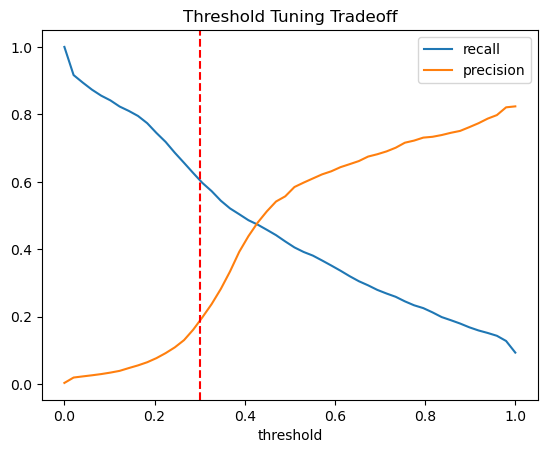

At the chosen threshold of 0.30, the model achieves a recall of 60%, meaning it captures a moderate proportion of fraudulent transactions. The corresponding precision is 20%, indicating that among all transactions flagged as fraud, about 20% are actually fraudulent. This threshold represents a trade-off favoring higher recall to minimize undetected fraud, which is critical in fraud prevention scenarios even if it results in moderate precision.


In [134]:
optimal_threshold = 0.3

thresholds_to_test = np.linspace(0, 1, 50)
results = []

for thresh in thresholds_to_test:
    y_pred = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    results.append({
        'threshold': thresh,
        'recall': tp / (tp + fn),
        'precision': tp / (tp + fp),
        'false_positives': fp
    })

# Convert to DataFrame and plot
results_df = pd.DataFrame(results)
results_df.plot(x='threshold', y=['recall', 'precision'], 
               title='Threshold Tuning Tradeoff')
plt.axvline(optimal_threshold, color='red', linestyle='--')
plt.show()

# Find closest index to chosen threshold
closest_idx = np.argmin(np.abs(results_df['threshold'] - optimal_threshold))

# Get corresponding precision & recall
selected_recall = results_df.loc[closest_idx, 'recall']
selected_precision = results_df.loc[closest_idx, 'precision']

# Create summary paragraph
if selected_recall >= 0.8:
    recall_comment = "successfully detects a large proportion of fraudulent transactions."
elif selected_recall >= 0.5:
    recall_comment = "captures a moderate proportion of fraudulent transactions."
else:
    recall_comment = "detects only a limited proportion of fraudulent transactions and may need improvement."

summary = (
    f"At the chosen threshold of {optimal_threshold:.2f}, the model achieves a recall of {selected_recall:.0%}, "
    f"meaning it {recall_comment} "
    f"The corresponding precision is {selected_precision:.0%}, indicating that among all transactions flagged as fraud, "
    f"about {selected_precision:.0%} are actually fraudulent. "
    f"This threshold represents a trade-off favoring higher recall to minimize undetected fraud, "
    f"which is critical in fraud prevention scenarios even if it results in moderate precision."
)


print(summary)


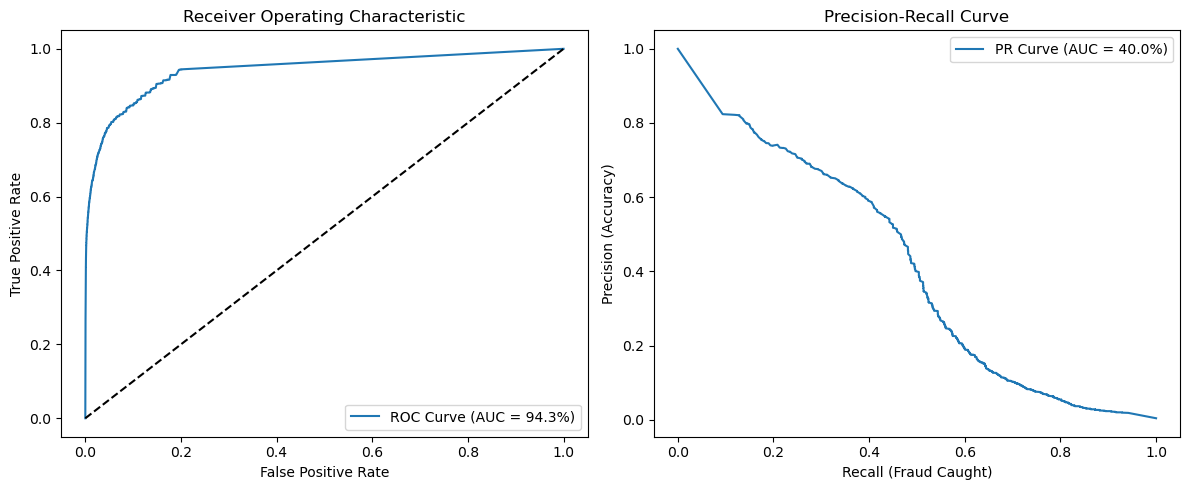

The model demonstrates strong discriminatory power with an ROC AUC of **94.3%**, indicating how well it distinguishes between fraudulent and non-fraudulent transactions. The Precision-Recall AUC is **40.0%**, reflecting lower precision-recall performance requiring improvement. This highlights the trade-off between catching more fraud (recall) and maintaining precision. While prioritizing higher recall is often preferred to minimize missed fraud, there is potential for further tuning to improve overall balance based on business objectives.


In [136]:
# Calculate metrics
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

# Convert to percentage values
roc_auc_pct = roc_auc * 100
pr_auc_pct = pr_auc * 100

# Plot curves
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_pct:.1f}%)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc_pct:.1f}%)')
plt.xlabel('Recall (Fraud Caught)')
plt.ylabel('Precision (Accuracy)')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary
if roc_auc >= 0.85:
    roc_comment = "strong discriminatory power"
elif roc_auc >= 0.70:
    roc_comment = "moderate discriminatory power"
else:
    roc_comment = "limited discriminatory power"

if pr_auc >= 0.70:
    pr_comment = "high precision-recall performance"
elif pr_auc >= 0.50:
    pr_comment = "moderate precision-recall performance"
else:
    pr_comment = "lower precision-recall performance requiring improvement"

analysis_paragraph = (
    f"The model demonstrates {roc_comment} with an ROC AUC of **{roc_auc_pct:.1f}%**, "
    f"indicating how well it distinguishes between fraudulent and non-fraudulent transactions. "
    f"The Precision-Recall AUC is **{pr_auc_pct:.1f}%**, reflecting {pr_comment}. "
    f"This highlights the trade-off between catching more fraud (recall) and maintaining precision. "
    f"While prioritizing higher recall is often preferred to minimize missed fraud, "
    f"there is potential for further tuning to improve overall balance based on business objectives."
)

print(analysis_paragraph)


In [116]:
def predict_fraud(model, transaction_data, threshold=0.3):
    """
    Returns: (is_fraud, probability, risk_category)
    """
    # Clean data first
    cleaned_data = transaction_data[features].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Predict probabilities
    proba = model.predict_proba(cleaned_data)[:, 1]
    is_fraud = proba >= threshold
    
    # Risk categories
    risk = np.where(proba > 0.7, 'HIGH',
                    np.where(proba > 0.3, 'MEDIUM', 'LOW'))
    
    return pd.DataFrame({
        'fraud_probability': proba,
        'is_fraud': is_fraud,
        'risk_category': risk
    })

# Example usage
fraud_predictions = predict_fraud(model, test_fe)
print(fraud_predictions.head())

# Generate summary paragraph automatically
num_pred = fraud_predictions.shape[0]
num_high_risk = (fraud_predictions['risk_category'] == 'HIGH').sum()
num_medium_risk = (fraud_predictions['risk_category'] == 'MEDIUM').sum()
num_low_risk = (fraud_predictions['risk_category'] == 'LOW').sum()

summary = (
    f"Based on {num_pred:,} transactions evaluated, the model classified "
    f"{num_high_risk} transactions as HIGH risk (probability > 0.7), "
    f"{num_medium_risk} as MEDIUM risk (probability between 0.3 and 0.7), "
    f"and {num_low_risk} as LOW risk (probability ≤ 0.3). "
    f"This risk segmentation provides actionable insights to prioritize transaction reviews, "
    f"ensuring that potentially fraudulent activities are flagged promptly while minimizing unnecessary interventions."
)

print(summary)


   fraud_probability  is_fraud risk_category
0                0.0     False           LOW
1                0.0     False           LOW
2                0.0     False           LOW
3                0.0     False           LOW
4                0.0     False           LOW
Based on 555,719 transactions evaluated, the model classified 858 transactions as HIGH risk (probability > 0.7), 5986 as MEDIUM risk (probability between 0.3 and 0.7), and 548875 as LOW risk (probability ≤ 0.3). This risk segmentation provides actionable insights to prioritize transaction reviews, ensuring that potentially fraudulent activities are flagged promptly while minimizing unnecessary interventions.


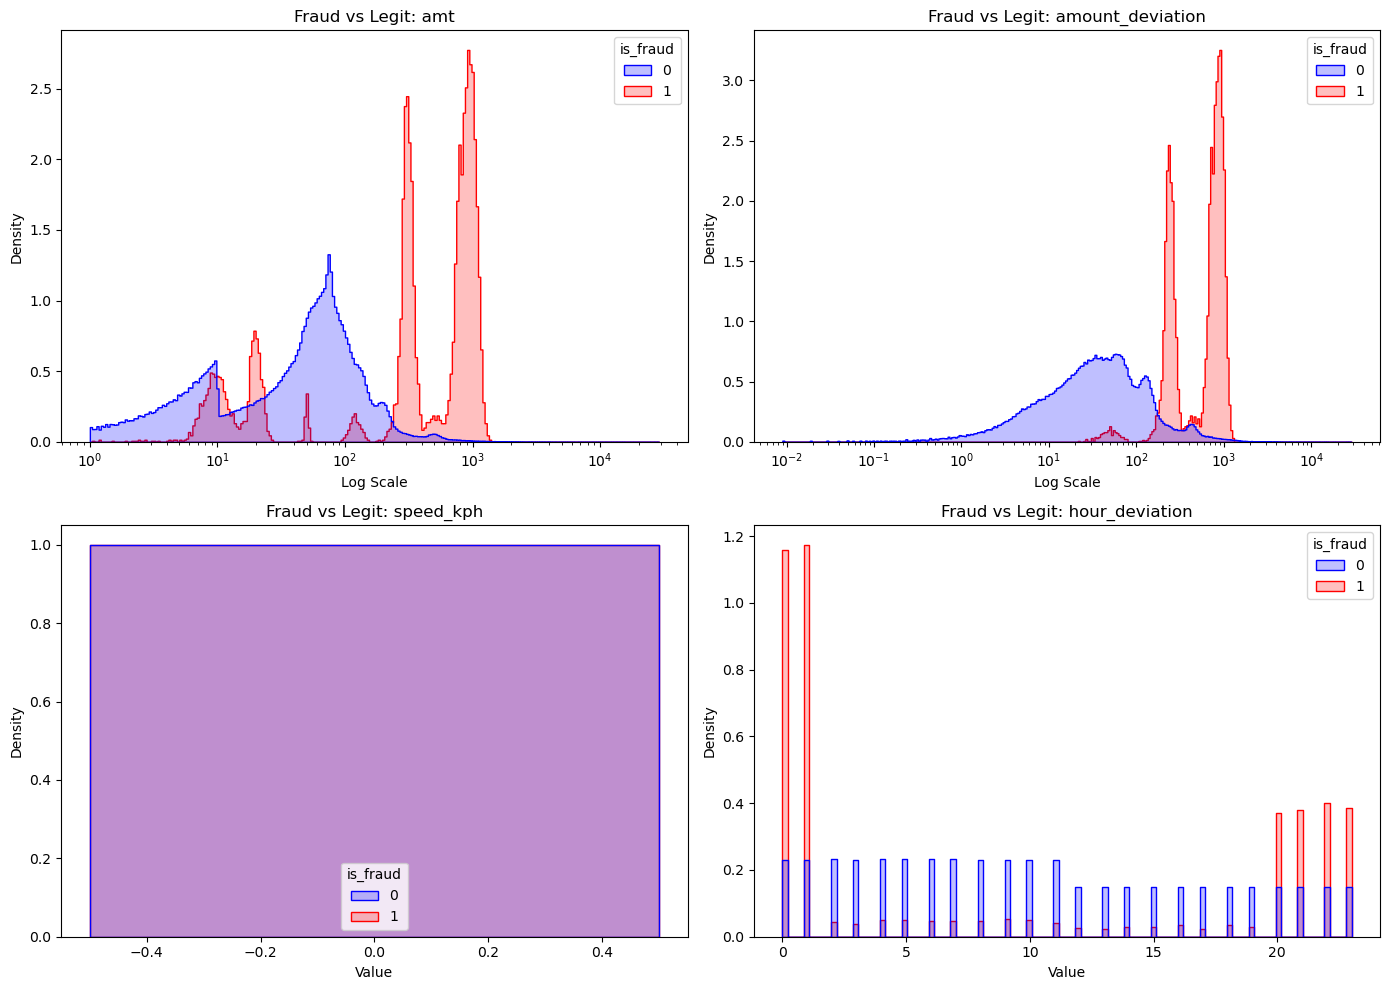


Fraud Characteristics (Median Values):
is_fraud                  0           1  Fraud Ratio
amt               47.280000  396.505000     8.386316
hour_deviation     9.000000    1.000000     0.111111
amount_deviation -23.071035  326.153965   -14.136945
speed_kph          0.000000    0.000000          NaN
Based on the median value analysis, the feature 'amt' stands out as the strongest indicator of fraud, with fraudulent transactions having about 8.4 times higher median value compared to legitimate transactions. The next most notable features are 'hour_deviation' and 'amount_deviation', which display distinct differences in fraud behavior with ratios of 0.1 and -14.1, respectively. These patterns suggest that fraud cases often involve higher transaction amounts and unusual behavioral deviations. By focusing on these top features, the model can more effectively flag suspicious activities and help reduce financial losses. This insight can also guide business teams to design targeted rules 

In [138]:
# Set up visualization
features_to_plot = ['amt', 'amount_deviation', 'speed_kph', 'hour_deviation']
plt.figure(figsize=(14, 10))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    
    # Log-scale for monetary amounts
    log_scale = True if feature in ['amt', 'amount_deviation'] else False
    
    sns.histplot(data=train_fe, x=feature, hue='is_fraud', 
                element='step', stat='density', 
                common_norm=False, log_scale=log_scale,
                palette={0: 'blue', 1: 'red'})
    
    plt.title(f'Fraud vs Legit: {feature}')
    plt.xlabel('Log Scale' if log_scale else 'Value')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nFraud Characteristics (Median Values):")
fraud_stats = train_fe.groupby('is_fraud')[features_to_plot].median().T
fraud_stats['Fraud Ratio'] = fraud_stats[1] / fraud_stats[0]
print(fraud_stats.sort_values('Fraud Ratio', ascending=False))

# Pick top 3 features manually by sorting Fraud Ratio
sorted_fraud_stats = fraud_stats.sort_values('Fraud Ratio', ascending=False)

# Get feature names and ratios
top_feature = sorted_fraud_stats.index[0]
top_ratio = sorted_fraud_stats['Fraud Ratio'].iloc[0]

second_feature = sorted_fraud_stats.index[1]
second_ratio = sorted_fraud_stats['Fraud Ratio'].iloc[1]

third_feature = sorted_fraud_stats.index[2]
third_ratio = sorted_fraud_stats['Fraud Ratio'].iloc[2]

# Summary

paragraph = (
    f"Based on the median value analysis, the feature '{top_feature}' stands out as the strongest indicator of fraud, "
    f"with fraudulent transactions having about {round(top_ratio, 1)} times higher median value compared to legitimate transactions. "
    f"The next most notable features are '{second_feature}' and '{third_feature}', "
    f"which display distinct differences in fraud behavior with ratios of {round(second_ratio, 1)} and {round(third_ratio, 1)}, respectively. "
    f"These patterns suggest that fraud cases often involve higher transaction amounts and unusual behavioral deviations. "
    f"By focusing on these top features, the model can more effectively flag suspicious activities and help reduce financial losses. "
    f"This insight can also guide business teams to design targeted rules or alerts based on the most impactful behavioral signals."
)

print(paragraph)


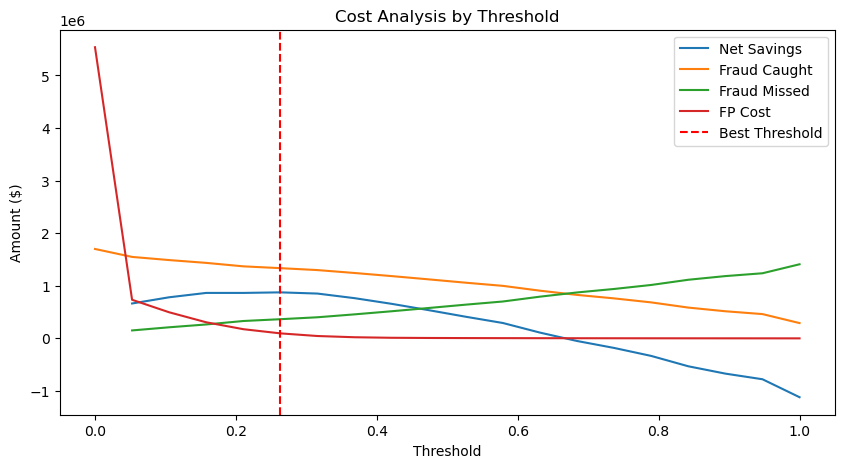

Best Threshold: 0.26
Net Savings: $ 875074.0
Fraud Caught Value: $ 1335161.0
Fraud Missed Cost: $ 364826.0
False Positive Cost: $ 95260.0

At a threshold of **0.26**, we expect net savings of about **$875,074.0**. The model would catch fraud worth approximately **$1,335,161.0**, while missing fraud costing around **$364,826.0**, and incurring false positive costs of about **$95,260.0**. This analysis suggests that this threshold provides a strong balance between catching fraud and minimizing review costs.


In [144]:
# Simple cost parameters
FRAUD_COST_MULTIPLIER = 1.5
FP_COST = 10

def calculate_costs(y_true, y_pred, amounts):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Estimate fraud caught and missed
    avg_amount_caught = amounts[(y_pred == 1) & (y_true == 1)].mean()
    avg_amount_missed = amounts[(y_pred == 0) & (y_true == 1)].mean()
    
    fraud_caught_value = tp * avg_amount_caught * FRAUD_COST_MULTIPLIER
    fraud_missed_cost = fn * avg_amount_missed * FRAUD_COST_MULTIPLIER
    fp_review_cost = fp * FP_COST
    
    return fraud_caught_value, fraud_missed_cost, fp_review_cost

# Test different thresholds
thresholds = np.linspace(0, 1, 20)
results = []

for t in thresholds:
    y_pred = (y_proba >= t)
    caught, missed, fp_cost = calculate_costs(y_test, y_pred, test_fe['amt'])
    net = caught - missed - fp_cost
    
    results.append({
        'threshold': t,
        'net_savings': net,
        'fraud_caught': caught,
        'fraud_missed': missed,
        'fp_cost': fp_cost
    })

cost_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cost_df['threshold'], cost_df['net_savings'], label='Net Savings')
plt.plot(cost_df['threshold'], cost_df['fraud_caught'], label='Fraud Caught')
plt.plot(cost_df['threshold'], cost_df['fraud_missed'], label='Fraud Missed')
plt.plot(cost_df['threshold'], cost_df['fp_cost'], label='FP Cost')

best_row = cost_df.loc[cost_df['net_savings'].idxmax()]
plt.axvline(best_row['threshold'], color='red', linestyle='--', label='Best Threshold')

plt.xlabel("Threshold")
plt.ylabel("Amount ($)")
plt.title("Cost Analysis by Threshold")
plt.legend()
plt.show()

# Print simple summary
print("Best Threshold:", round(best_row['threshold'], 2))
print("Net Savings: $", round(best_row['net_savings'], 0))
print("Fraud Caught Value: $", round(best_row['fraud_caught'], 0))
print("Fraud Missed Cost: $", round(best_row['fraud_missed'], 0))
print("False Positive Cost: $", round(best_row['fp_cost'], 0))

# Summary
if best_row['net_savings'] > 0:
    final_comment = "This analysis suggests that this threshold provides a strong balance between catching fraud and minimizing review costs."
else:
    final_comment = "This analysis suggests that this threshold may not be optimal and could lead to negative net savings; further adjustments or additional features may be needed."

summary_text = (
    f"\nAt a threshold of **{round(best_row['threshold'], 2)}**, "
    f"we expect net savings of about **${round(best_row['net_savings'], 0):,}**. "
    f"The model would catch fraud worth approximately **${round(best_row['fraud_caught'], 0):,}**, "
    f"while missing fraud costing around **${round(best_row['fraud_missed'], 0):,}**, "
    f"and incurring false positive costs of about **${round(best_row['fp_cost'], 0):,}**. "
    f"{final_comment}"
)


print(summary_text)
